### Prepare PCA interpolation paths (negative control)

In [1]:
import mdtraj as md
import pyemma as pm

from sklearn.decomposition import PCA

import sys
from pathlib import Path
import os
import pickle
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
title = 'CLN_pca'
storage_path = Path(f'./data/init_paths/{title}')
model_path = Path(f'./data/CLN_msm/')

top_path = Path('./data/CLN_msm//protein.pdb')
ref_unfolded_path = Path('./data/init_paths/CLN_md/unfolded_no_sol.pdb')
ref_folded_path = Path('./data/CLN_msm/5AWL_H.pdb')
traj_paths = [str(x) for x in Path(r'./data/CLN_msm').rglob(f'CLN025-0-protein-*.xtc')]
traj_paths.sort()

storage_path.mkdir(exist_ok=True)

In [3]:
trajs = md.load(traj_paths, top=top_path)
ref_folded = md.load(ref_folded_path)
ref_unfolded = md.load(ref_unfolded_path)
trajs.superpose(ref_folded)

<mdtraj.Trajectory with 106949 frames, 166 atoms, 10 residues, and unitcells at 0x7f1286e8b820>

In [14]:
n_component = 12
pca = PCA(n_components=n_component)
reduce_traj = pca.fit_transform(trajs.xyz.reshape(trajs.n_frames, trajs.n_atoms*3))

In [15]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.43701181 0.07704318 0.05817338 0.03888186 0.03597892 0.02932839
 0.02688937 0.02558427 0.02118198 0.02037599 0.0171218  0.01592978]
0.8035007273361566


In [28]:
n_inter = 10
reduced_folded = pca.transform((ref_folded.xyz.reshape(1, ref_folded.n_atoms*3)))
reduced_unfolded = pca.transform((ref_unfolded.xyz.reshape(1, ref_unfolded.n_atoms*3)))
intp = np.linspace(reduced_folded[0], reduced_unfolded[0], n_inter)
pca_traj = pca.inverse_transform(intp).reshape(n_inter, ref_folded.n_atoms, 3)

In [29]:
transition_no_sol_pca = md.Trajectory(xyz=pca_traj, topology=ref_folded.topology)
transition_no_sol_pca.save(storage_path.joinpath(f'transition_no_sol_{n_inter}frames_{n_component}components.pdb'))

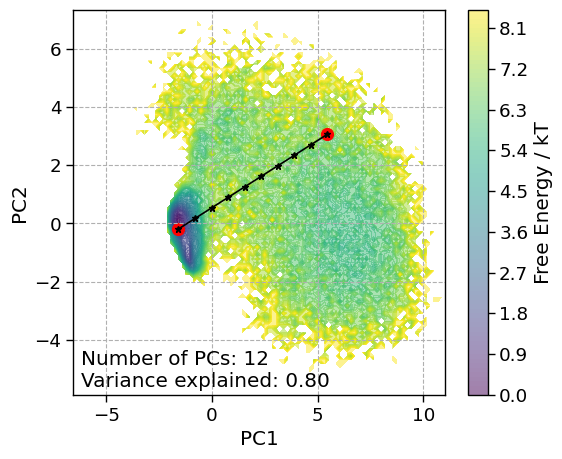

In [27]:
# FES using the principal components
# Pin the folded and unfolded state and find the interpolations

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    ax.grid(visible=True, axis='both', ls='--')
    _, _ = pm.plots.plot_free_energy(reduce_traj[:, 0], reduce_traj[:, 1], cmap='viridis', 
                                alpha=0.5, 
                                cbar_label='Free Energy / kT', 
                                ax=ax)
    ax.scatter(reduced_folded[0][0], reduced_folded[0][1], 
               s=300, c='Red', marker='.', label='Folded')
    ax.scatter(reduced_unfolded[0][0], reduced_unfolded[0][1], 
               s=300, c='Red', marker='.', label='unfolded')
    ax.plot(intp[:,0], intp[:,1], c='k', marker='*')
    ax.annotate(text=f'Number of PCs: {n_component}\nVariance explained: {sum(pca.explained_variance_ratio_):.2f}',
                xy=(0.02, 0.01), xycoords='axes fraction', ha='left', va='bottom')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.savefig(storage_path.joinpath(f'FES_{n_component}_.png'))
    plt.show()